# Civic Project: Using Pluto data and Disclosure data for Local Law 84

In [1]:
import geopandas as gp
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pylab as pl
import math
pl.style.use('ggplot')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Index
1. Data Wrangling
2. Regressions
3. Predictions
4. Further Data Selection
  1. Regressions
  2. Predictions
5. Estimation Approach 1
6. Estimations of GHG
7. Estimation Approach 3

# 1. Data Wrangling

In [2]:
# Read Brooklyn data, select relevant columns
pluto_br = gp.read_file('Brooklyn/BKMapPLUTO.shp')
pluto_br = pluto_br[['BBL','BldgArea', 'BldgClass', 'Block', 'Borough','ComArea','LandUse', 'LotArea', 
               'OfficeArea', 'OwnerType', 'ResArea', 'RetailArea','UnitsTotal','UnitsRes', 'YearBuilt',]]
pluto_br = pluto_br[pluto_br['UnitsTotal']>0]

In [3]:
# Read Manhattan data, select relevant columns
pluto_ma = gp.read_file('Manhattan/MNMapPLUTO.shp')
pluto_ma = pluto_ma[['BBL','BldgArea', 'BldgClass', 'Block', 'Borough','ComArea','LandUse', 'LotArea', 
               'OfficeArea', 'OwnerType', 'ResArea', 'RetailArea','UnitsTotal','UnitsRes', 'YearBuilt',]]
pluto_ma = pluto_ma[pluto_ma['UnitsTotal']>0]

In [4]:
# Compute possible predictors
pluto_br['UnitsOffice'] = pluto_br['UnitsTotal'] - pluto_br['UnitsRes']
pluto_ma['UnitsOffice'] = pluto_ma['UnitsTotal'] - pluto_ma['UnitsRes']

In [5]:
# Read disclosure data, select relevant columns
energy = pd.read_csv('Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv')
energy['BBL'] = energy['NYC Borough, Block, and Lot (BBL)']
energy = energy[['Borough','BBL','Zip Code','Site EUI(kBtu/ft2)','Weather Normalized Site EUI(kBtu/ft2)', 
                 'Source EUI(kBtu/ft2)','Weather Normalized Source EUI(kBtu/ft2)','ENERGY STAR Score',
                 'Total GHG Emissions(MtCO2e)','Reported Property Floor Area (Building(s)) (ft²)']]

In [6]:
# Convert datatype of values in relevant columns to numeric
energy['Site EUI(kBtu/ft2)'] = energy['Site EUI(kBtu/ft2)'].convert_objects(convert_numeric=True)
energy['Total GHG Emissions(MtCO2e)'] = energy['Total GHG Emissions(MtCO2e)'].convert_objects(convert_numeric=True)
energy['Reported Property Floor Area (Building(s)) (ft²)'] = energy['Reported Property Floor Area (Building(s)) (ft²)'].convert_objects(convert_numeric=True)
energy['Weather Normalized Site EUI(kBtu/ft2)'] = energy['Weather Normalized Site EUI(kBtu/ft2)'].convert_objects(convert_numeric=True)
energy['Source EUI(kBtu/ft2)'] = energy['Source EUI(kBtu/ft2)'].convert_objects(convert_numeric=True)
energy['Weather Normalized Source EUI(kBtu/ft2)'] = energy['Weather Normalized Source EUI(kBtu/ft2)'].convert_objects(convert_numeric=True)
energy['ENERGY STAR Score'] = energy['ENERGY STAR Score'].convert_objects(convert_numeric=True)

In [7]:
# Merge pluto data
pluto = pluto_br.append(pluto_ma)

In [8]:
# Rename columns for future regression
energy.rename(columns={'Site EUI(kBtu/ft2)':'EUI','Weather Normalized Site EUI(kBtu/ft2)':'NormEUI',
                     'Source EUI(kBtu/ft2)':'SourceEUI','Weather Normalized Source EUI(kBtu/ft2)':'NormSourceEUI',
                     'Total GHG Emissions(MtCO2e)':'GHG',
                     'Reported Property Floor Area (Building(s)) (ft²)':'FloorArea'},inplace=True)

In [9]:
# Delete impossible observations
pluto = pluto[pluto['UnitsTotal']>0]
energy = energy[(energy['EUI']>0) & (energy['GHG']>0)]    

In [10]:
# Compute possible predictors
pluto['TotalArea'] = pluto['ComArea'] + pluto['OfficeArea'] + pluto['ResArea'] + pluto['RetailArea']  

In [11]:
# Merge dataset
data = pd.merge(pluto, energy, on='BBL', how='inner')

In [12]:
# Add 1 to the following column values in order to exercise logarithmic transformation later on
k = ['FloorArea','OfficeArea','ResArea','ComArea','RetailArea']
for i in k:
    data.ix[data[i] == 0,i] = 1 

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7081 entries, 0 to 7080
Data columns (total 26 columns):
BBL                  7081 non-null float64
BldgArea             7081 non-null int64
BldgClass            7081 non-null object
Block                7081 non-null int64
Borough_x            7081 non-null object
ComArea              7081 non-null int64
LandUse              7080 non-null object
LotArea              7081 non-null int64
OfficeArea           7081 non-null int64
OwnerType            2729 non-null object
ResArea              7081 non-null int64
RetailArea           7081 non-null int64
UnitsTotal           7081 non-null int64
UnitsRes             7081 non-null int64
YearBuilt            7081 non-null int64
UnitsOffice          7081 non-null int64
TotalArea            7081 non-null int64
Borough_y            7081 non-null object
Zip Code             6579 non-null float64
EUI                  7081 non-null float64
NormEUI              6105 non-null float64
SourceEUI          

In [14]:
data['LandUse'].value_counts()

03    3388
04    1615
05    1267
08     347
06     276
02     155
10      26
07       5
09       1
dtype: int64

In [15]:
# Select only Office Building based on land use 05
data05 = data[data['LandUse']=='05']
data05.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1267 entries, 4 to 7059
Data columns (total 26 columns):
BBL                  1267 non-null float64
BldgArea             1267 non-null int64
BldgClass            1267 non-null object
Block                1267 non-null int64
Borough_x            1267 non-null object
ComArea              1267 non-null int64
LandUse              1267 non-null object
LotArea              1267 non-null int64
OfficeArea           1267 non-null int64
OwnerType            645 non-null object
ResArea              1267 non-null int64
RetailArea           1267 non-null int64
UnitsTotal           1267 non-null int64
UnitsRes             1267 non-null int64
YearBuilt            1267 non-null int64
UnitsOffice          1267 non-null int64
TotalArea            1267 non-null int64
Borough_y            1267 non-null object
Zip Code             1132 non-null float64
EUI                  1267 non-null float64
NormEUI              1026 non-null float64
SourceEUI           

In [16]:
# Select only Public Facilities and Institutions based on land use 08
data08 = data[data['LandUse']=='08']
data08.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 347 entries, 25 to 7073
Data columns (total 26 columns):
BBL                  347 non-null float64
BldgArea             347 non-null int64
BldgClass            347 non-null object
Block                347 non-null int64
Borough_x            347 non-null object
ComArea              347 non-null int64
LandUse              347 non-null object
LotArea              347 non-null int64
OfficeArea           347 non-null int64
OwnerType            291 non-null object
ResArea              347 non-null int64
RetailArea           347 non-null int64
UnitsTotal           347 non-null int64
UnitsRes             347 non-null int64
YearBuilt            347 non-null int64
UnitsOffice          347 non-null int64
TotalArea            347 non-null int64
Borough_y            347 non-null object
Zip Code             300 non-null float64
EUI                  347 non-null float64
NormEUI              275 non-null float64
SourceEUI            347 non-null float6

# 2. Regressions

#### For office buildings. EUI on Floor Area, since Retail Area is not significant.

In [17]:
model = smf.ols('np.log(NormSourceEUI) ~ np.log(FloorArea)', data=data05, missing='drop').fit()
print model.summary()

                              OLS Regression Results                             
Dep. Variable:     np.log(NormSourceEUI)   R-squared:                       0.004
Model:                               OLS   Adj. R-squared:                  0.003
Method:                    Least Squares   F-statistic:                     3.941
Date:                   Thu, 29 Oct 2015   Prob (F-statistic):             0.0474
Time:                           19:52:48   Log-Likelihood:                -1270.5
No. Observations:                   1018   AIC:                             2545.
Df Residuals:                       1016   BIC:                             2555.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercep

#### For all building types. EUI on Office Area and Retail Area.

In [18]:
model1 = smf.ols('np.log(NormSourceEUI) ~ np.log(OfficeArea) + np.log(RetailArea) ', data=data, missing='drop').fit()
print model1.summary()

                              OLS Regression Results                             
Dep. Variable:     np.log(NormSourceEUI)   R-squared:                       0.052
Model:                               OLS   Adj. R-squared:                  0.052
Method:                    Least Squares   F-statistic:                     167.9
Date:                   Thu, 29 Oct 2015   Prob (F-statistic):           1.03e-71
Time:                           19:52:48   Log-Likelihood:                -7251.6
No. Observations:                   6105   AIC:                         1.451e+04
Df Residuals:                       6102   BIC:                         1.453e+04
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Interc

#### For Institutions. EUI on Office Area and Retail Area. Not significant.

In [19]:
model2 = smf.ols('np.log(NormSourceEUI) ~ np.log(OfficeArea) + np.log(RetailArea) ', data=data08, missing='drop').fit()
print model2.summary()

                              OLS Regression Results                             
Dep. Variable:     np.log(NormSourceEUI)   R-squared:                       0.007
Model:                               OLS   Adj. R-squared:                 -0.000
Method:                    Least Squares   F-statistic:                    0.9407
Date:                   Thu, 29 Oct 2015   Prob (F-statistic):              0.392
Time:                           19:52:48   Log-Likelihood:                -500.76
No. Observations:                    275   AIC:                             1008.
Df Residuals:                        272   BIC:                             1018.
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Interc

#### For Institutions types. EUI on Floor Area. Not significant.

In [20]:
model3 = smf.ols('np.log(NormSourceEUI) ~ np.log(FloorArea)', data=data08, missing='drop').fit()
print model3.summary()

                              OLS Regression Results                             
Dep. Variable:     np.log(NormSourceEUI)   R-squared:                       0.001
Model:                               OLS   Adj. R-squared:                 -0.002
Method:                    Least Squares   F-statistic:                    0.3752
Date:                   Thu, 29 Oct 2015   Prob (F-statistic):              0.541
Time:                           19:52:48   Log-Likelihood:                -501.52
No. Observations:                    275   AIC:                             1007.
Df Residuals:                        273   BIC:                             1014.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercep

#### For office buildings. EUI on number of total units. Even though not relevant.

In [21]:
model4 = smf.ols('np.log(NormSourceEUI) ~ np.log(UnitsTotal)', data=data05, missing='drop').fit()
print model4.summary()

                              OLS Regression Results                             
Dep. Variable:     np.log(NormSourceEUI)   R-squared:                       0.017
Model:                               OLS   Adj. R-squared:                  0.016
Method:                    Least Squares   F-statistic:                     17.24
Date:                   Thu, 29 Oct 2015   Prob (F-statistic):           3.57e-05
Time:                           19:52:48   Log-Likelihood:                -1270.8
No. Observations:                   1026   AIC:                             2546.
Df Residuals:                       1024   BIC:                             2555.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Interc

#### For office buildings. EUI on number of office units. Even though not relevant.

In [22]:
model5 = smf.ols('np.log(NormSourceEUI) ~ np.log(UnitsOffice)', data=data05, missing='drop').fit()
print model5.summary()

                              OLS Regression Results                             
Dep. Variable:     np.log(NormSourceEUI)   R-squared:                       0.014
Model:                               OLS   Adj. R-squared:                  0.013
Method:                    Least Squares   F-statistic:                     14.70
Date:                   Thu, 29 Oct 2015   Prob (F-statistic):           0.000134
Time:                           19:52:48   Log-Likelihood:                -1272.1
No. Observations:                   1026   AIC:                             2548.
Df Residuals:                       1024   BIC:                             2558.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Inte

# 3. Actual Predictions based on best models

#### For office buildings. EUI on Floor Area.

In [23]:
# Predict EUI of 370 Jay Street based on model:
y = model.params[0] + model.params[1]*np.log(450000)
print 'Predicted EUI:', math.exp(y)

Predicted EUI: 220.226206713


In [24]:
data.FloorArea.describe()

count       7073.000000
mean      187321.349215
std       302952.057492
min          500.000000
25%        68402.000000
50%       102053.000000
75%       182980.000000
max      9515627.000000
Name: FloorArea, dtype: float64

#### For all building types. EUI on Floor Area.

In [25]:
# Predict EUI of 370 Jay Street based on model:
y = model3.params[0] + model3.params[1]*np.log(450000)
print 'Predicted EUI:', math.exp(y)

Predicted EUI: 190.547224815


# 4. Clean dataset further
#### Getting rid of potential outliers

In [26]:
data_clean = data[(data.FloorArea>1000) & (data.UnitsTotal >= 10) & (data.UnitsTotal < 1000)]

In [27]:
data05_clean = data_clean[data_clean['LandUse']=='05']
data05_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 753 entries, 4 to 7059
Data columns (total 26 columns):
BBL                  753 non-null float64
BldgArea             753 non-null int64
BldgClass            753 non-null object
Block                753 non-null int64
Borough_x            753 non-null object
ComArea              753 non-null int64
LandUse              753 non-null object
LotArea              753 non-null int64
OfficeArea           753 non-null int64
OwnerType            390 non-null object
ResArea              753 non-null int64
RetailArea           753 non-null int64
UnitsTotal           753 non-null int64
UnitsRes             753 non-null int64
YearBuilt            753 non-null int64
UnitsOffice          753 non-null int64
TotalArea            753 non-null int64
Borough_y            753 non-null object
Zip Code             685 non-null float64
EUI                  753 non-null float64
NormEUI              575 non-null float64
SourceEUI            753 non-null float64

# 4.B Actual Regressions

In [28]:
model_clean = smf.ols('np.log(NormSourceEUI) ~ np.log(FloorArea)', data=data05_clean, missing='drop').fit()
print model_clean.summary()

                              OLS Regression Results                             
Dep. Variable:     np.log(NormSourceEUI)   R-squared:                       0.045
Model:                               OLS   Adj. R-squared:                  0.044
Method:                    Least Squares   F-statistic:                     27.23
Date:                   Thu, 29 Oct 2015   Prob (F-statistic):           2.53e-07
Time:                           19:52:48   Log-Likelihood:                -600.68
No. Observations:                    575   AIC:                             1205.
Df Residuals:                        573   BIC:                             1214.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercep

#### Model improved considerably.

In [29]:
model_clean1 = smf.ols('np.log(NormSourceEUI) ~ np.log(UnitsTotal)', data=data05_clean, missing='drop').fit()
print model_clean1.summary()

                              OLS Regression Results                             
Dep. Variable:     np.log(NormSourceEUI)   R-squared:                       0.000
Model:                               OLS   Adj. R-squared:                 -0.001
Method:                    Least Squares   F-statistic:                    0.2114
Date:                   Thu, 29 Oct 2015   Prob (F-statistic):              0.646
Time:                           19:52:48   Log-Likelihood:                -613.93
No. Observations:                    575   AIC:                             1232.
Df Residuals:                        573   BIC:                             1241.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Interc

#### This model is not relevant

In [30]:
model_clean2 = smf.ols('np.log(NormSourceEUI) ~ np.log(RetailArea+1) + np.log(OfficeArea)', data=data05_clean, missing='drop').fit()
print model_clean2.summary()

                              OLS Regression Results                             
Dep. Variable:     np.log(NormSourceEUI)   R-squared:                       0.004
Model:                               OLS   Adj. R-squared:                  0.000
Method:                    Least Squares   F-statistic:                     1.032
Date:                   Thu, 29 Oct 2015   Prob (F-statistic):              0.357
Time:                           19:52:48   Log-Likelihood:                -613.00
No. Observations:                    575   AIC:                             1232.
Df Residuals:                        572   BIC:                             1245.
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------

#### Retail and office area is not significant

# 4.B Actual Predictions based on best models. Clean Dataset.
Based on floor area for office buildings, deleting leverage points and outliers.

In [54]:
y_clean = model_clean.params[0] + model_clean.params[1]*np.log(450000)
eui = math.exp(y_clean)
print 'Predicted EUI:', eui, 'in log:', y_clean

Predicted EUI: 212.017886085 in log: 5.35667063944


### Just educational buildings
W5 = City University
W6 = Other Colleges and Universities

In [32]:
dataO = data[(data['BldgClass']=='W5') | (data['BldgClass']=='W6')]

In [33]:
data['BldgClass'].value_counts()

D4    1622
D1     972
RM     826
D7     382
O3     315
D6     299
D3     255
O9     231
R4     202
D9     156
O2     156
O4     134
C1     101
RC      77
D8      64
D0      59
W6      57
E7      56
C7      55
L1      53
H8      52
D5      43
H3      42
O1      42
H1      40
E9      37
RB      31
O5      29
H2      28
E1      24
      ... 
H9       2
W4       2
HH       2
RH       2
RA       2
M9       2
F2       2
P1       2
L3       2
RW       1
C0       1
G2       1
I2       1
C5       1
K5       1
H5       1
J9       1
H7       1
Y8       1
E4       1
Z9       1
Y3       1
C3       1
P8       1
R1       1
RK       1
O6       1
P6       1
F8       1
G6       1
dtype: int64

There is no data on this.

# 5. Estimation Approach 1

In [34]:
data05_clean['ENERGY STAR Score'].describe()

count    631.000000
mean      70.824089
std       20.913483
min        1.000000
25%       60.000000
50%       76.000000
75%       87.000000
max      100.000000
Name: ENERGY STAR Score, dtype: float64

In [35]:
# LEED Silver is equivalent to at least an ENERGY STAR Score of 50
summary = data[data['ENERGY STAR Score']==50]
summary.describe()['NormSourceEUI']

count      9.000000
mean     239.866667
std       72.027668
min       65.300000
25%      240.600000
50%      245.500000
75%      275.500000
max      315.000000
Name: NormSourceEUI, dtype: float64

In [36]:
# Same for cleaned dataset
summary_clean = data05_clean[data05_clean['ENERGY STAR Score']==50]
summary_clean.describe()['NormSourceEUI']

count      5.000000
mean     257.240000
std       22.772637
min      240.600000
25%      245.400000
50%      245.500000
75%      258.500000
max      296.200000
Name: NormSourceEUI, dtype: float64

As it turns out, the regression is not significant.

# 6. Estimating Greenhouse Gas Emissions (Total GHG Emissions)

In [50]:
ghg = smf.ols('np.log(GHG) ~ np.log(NormSourceEUI)', data=data05_clean, missing='drop').fit()
print ghg.summary()
detail = ghg.params[0] + ghg.params[1]*np.log(eui)
y = math.exp(detail)
print 'Predicted GHG Emissions:', y, 'in log:', detail

                            OLS Regression Results                            
Dep. Variable:            np.log(GHG)   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     546.1
Date:                Thu, 29 Oct 2015   Prob (F-statistic):           2.44e-85
Time:                        19:57:59   Log-Likelihood:                -795.38
No. Observations:                 575   AIC:                             1595.
Df Residuals:                     573   BIC:                             1603.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                 0.24

#### How this faires with other office buildings:

In [51]:
data05_clean['GHG'].describe()
median = data05_clean['GHG'].describe()[5]
median = np.log(median)

In [52]:
X = np.linspace(np.log(data05_clean['GHG'].min()),np.log(data05_clean['GHG'].max()),10)
Y = ghg.params[0] + ghg.params[1]*X

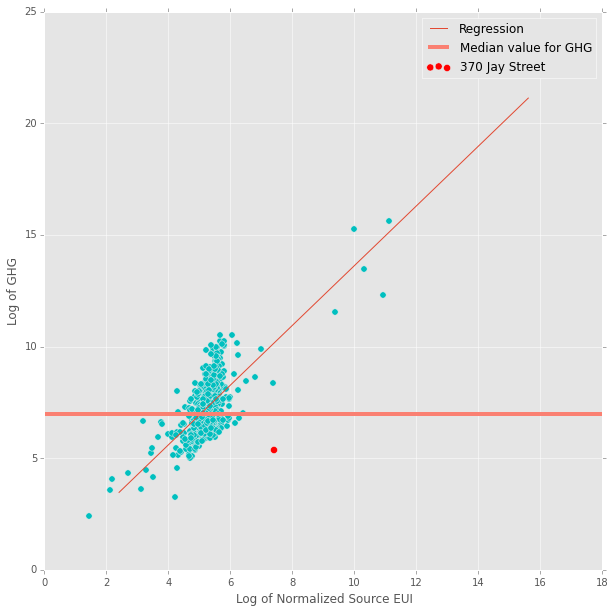

In [53]:
from statsmodels.graphics.api import abline_plot
figure, ax = pl.subplots(figsize=(10,10))
ax.scatter(np.log(data05_clean['NormSourceEUI']), np.log(data05_clean['GHG']),s=40,c='c')
ax.scatter(detail,np.log(eui),c='r',s=50, label='370 Jay Street')
ax.plot(X,Y, label='Regression')
ax.axhline(median,0,12, label='Median value for GHG',c='salmon', linewidth=4)
ax.set_ylabel('Log of GHG')
ax.set_xlabel('Log of Normalized Source EUI')
ax.legend()

The forecasted GHG emission level of 370 Jay Street is below median. 

In [41]:
data05_clean['GHG'][(data05_clean['NormSourceEUI']>200)&(data05_clean['NormSourceEUI']<250)].describe()

count      141.000000
mean      3157.147518
std       3789.083482
min        359.100000
25%        758.300000
50%       1807.800000
75%       4025.100000
max      24002.500000
Name: GHG, dtype: float64

In [42]:
detail = ghg.params[0] + ghg.params[1]*np.log(136.3)
y = math.exp(detail)
print 'Predicted GHG Emissions:', y, 'in log:', detail

Predicted GHG Emissions: 920.700835456 in log: 6.82513515771


### Normalized Site EUI for percentage share of block

In [43]:
site = smf.ols('np.log(NormEUI) ~ np.log(FloorArea)', data=data05_clean, missing='drop').fit()
print site.summary()
siteeui = site.params[0] + site.params[1]*np.log(450000)
e = math.exp(siteeui)
print 'Predicted Norm EUI:', e, 'in log:', siteeui

                            OLS Regression Results                            
Dep. Variable:        np.log(NormEUI)   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     14.59
Date:                Thu, 29 Oct 2015   Prob (F-statistic):           0.000148
Time:                        19:52:49   Log-Likelihood:                -640.89
No. Observations:                 575   AIC:                             1286.
Df Residuals:                     573   BIC:                             1294.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept             2.9359      0.39

In [44]:
print 'Share of block energy usage:',(e*100/2352872)*100,'%'

Share of block energy usage: 0.388122042667 %


# 7. Energy Star Portfolio Manager Estimation

In [45]:
star = pd.read_csv('EnergyStar.csv')
star

,Variables,NYU value,Reference Centering Value*,NYU adjusted value,Coefficient,Predicted independent value
0,Constant,NaN,NaN,NaN,186.6000,186.600000
1,Ln(Square Foot),13.038982,9.5350,3.503982,34.1700,119.731057
2,# of PCs per 1000 ft2,2.000000,2.2310,-0.231000,17.2800,-3.991680
3,Ln(Weekly Operating Hours),4.276666,3.9720,0.304666,55.9600,17.049116
4,Ln(Number of Workers per 1000 ft2),0.832909,0.5616,0.271309,10.3400,2.805336
5,HDD * % Heated,4691.100000,4411.0000,280.100000,0.0077,2.156770
6,CDD * % Cooled,1123.850000,1157.0000,-33.150000,0.0144,-0.477360


In [46]:
print 'Estimated Source EUI:', star['Predicted independent value'].sum()

Estimated Source EUI: 323.873239351
